In [48]:
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
import cosmoplots

from fppanalysis.running_moments import window_radius, run_norm_ds, run_mean_ds

from analysis_functions.constants import greenwald_fraction, shot_time_window
from analysis_functions.apd_functions import get_signal, get_time, get_rz, get_rz_full

from matplotlib.ticker import AutoMinorLocator, FixedFormatter, FixedLocator
from matplotlib import pyplot

### This code plots normalized time series for five diode view positions

In [49]:
shot = 1110201016

path = Path('/Users/ahe104/Box/mfe_data/raw_apd_data')
f_GW = greenwald_fraction[shot]
t_start = shot_time_window[shot][0]
t_end = shot_time_window[shot][1]

ds = xr.open_dataset(str(path) + '/' + f'apd_signal_array_{shot}.nc')

# Remove dead pixels
path_dead_pixel = Path('/Users/ahe104/Box/mfe_data/dead_pixels')
dead_pix = np.load(
    str(path_dead_pixel)
    + "/"
    + f"dead_pixels_shot_{shot}.npz"
)
dead_pix_arr = dead_pix['dead_pix_arr'] # Don't flip array, quiver plot is oriented this way
dead_pix_arr_ds = dead_pix_arr[::-1,:] # Flip array to match ds['frames'] orientation
for y in range(dead_pix_arr_ds.shape[0]):
    for x in range(dead_pix_arr_ds.shape[1]):
        if dead_pix_arr_ds[9-y, x]:
            ds['frames'].loc[dict(y=y, x=x)] = np.nan

# Slice and normalize signal
sliced_ds = ds.sel(time=slice(t_start, t_end))
radius = window_radius(1e3, sliced_ds.time.values)
norm_ds = run_norm_ds(sliced_ds, radius)
norm_ds = run_mean_ds(norm_ds, 3)

frames = norm_ds['frames']

In [32]:
color_list = ['#376CF5', '#785EF0', '#DC267F', '#FE6100', '#FFB000']

['#FE6100', '#785EF0']
[1.21205 1.2121  1.21215 1.21225 1.2123  1.21235 1.21245 1.2125  1.21255
 1.21265 1.2127  1.21275 1.21285 1.2129  1.21295]


Text(0, 0.5, '$\\widetilde{\\Phi}$')

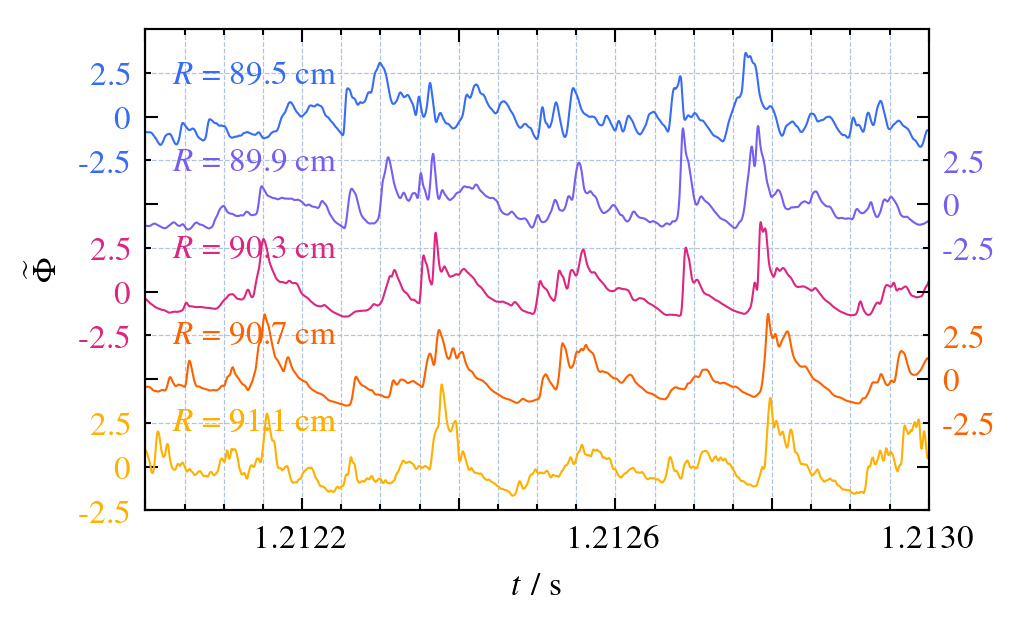

In [56]:
save = False
radial = True

axes_size = cosmoplots.set_rcparams_dynamo(plt.rcParams, num_cols=1, ls="thin")
plt.rcParams["font.size"] = 6
plt.rcParams["axes.labelsize"] = 8
plt.rcParams["xtick.labelsize"] = 8
plt.rcParams["ytick.labelsize"] = 8
plt.rcParams["xtick.major.size"] = 3
plt.rcParams["xtick.minor.size"] = 1.5
plt.rcParams["ytick.major.size"] = 3
plt.rcParams["ytick.minor.size"] = 1.5
plt.rcParams["ytick.minor.width"] = 0.5
plt.rcParams["xtick.minor.width"] = 0.5
plt.rcParams["ytick.major.width"] = 0.5
plt.rcParams["xtick.major.width"] = 0.5


# Plot time series
fig, ax = plt.subplots()

# Loop through pixels we want to analyse
if radial == True:
    pixels = np.arange(4, 9, 1)
else:
    pixels = np.arange(1, 10, 1)

# Make multiple boxes for labels
plot_lines = []
radial_positions = []

if radial == True:
    for idx, x_pixel in enumerate(pixels):
        # Choose a poloidal pixel location (row) to analyse
        y_pixel = 4
        dataset = frames.isel(x=x_pixel, y=y_pixel)
        R, Z = get_rz(x_pixel, y_pixel, ds)
        R_round = "{:0.1f}".format(R)
        Z_round = "{:0.1f}".format(Z)
        ll = ax.plot(dataset.time.values, dataset.values+(5*len(pixels-1)-5*(idx+1)), linewidth=0.5,color=color_list[idx], label=r'$R$ = 'f'{R_round} cm')#, linewitdh=0.2)
        ax.axhline(y=(5*len(pixels-1)-5*(idx+1))+2.5, linestyle='--', linewidth=0.3, zorder=0, color="lightsteelblue")

        plot_lines.append(ll)
        radial_positions.append(R_round)
else:
    for idx, y_pixel in enumerate(reversed(pixels)):
        x_pixel = 6
        dataset = frames.isel(x=x_pixel, y=y_pixel)

        R = format(dataset.R.values, '.1f')
        Z = format(dataset.Z.values, '.1f')
        ax.plot(dataset.time.values, dataset.values+(5*len(pixels-1)-5*(idx+1)), linewidth=0.5,color=color_list[idx], label=r'$Z$ = ' f'{Z} cm')#, linewitdh=0.2)
        ax.axhline(y=(5*len(pixels-1)-5*(idx+1))+2.5, linestyle='--', linewidth=0.3, zorder=0, color="lightsteelblue")


ax.set_xlim([1.212,1.213])

#------------------- Left y axis -------------------# 
# Define major tick and minor tick locations
major_yticks_left = [0, 5, 10, 15, 20]
minor_yticks_left = [-2.5, 2.5, 7.5, 12.5, 17.5, 22.5]

# Set tick locations
ax.set_yticks(major_yticks_left)
ax.set_yticks(minor_yticks_left, minor = True)

# Set minor ticks and labels on the left side
ax.set_yticklabels([0, "", 0, "", 0])
ax.set_yticklabels([-2.5, 2.5, -2.5, 2.5, -2.5, 2.5], minor=True)

#right_colors = [color_list[4], '#66CDAA', color_list[0]]
left_colors = color_list[::2][::-1]  # Get every second element reversed
N = 3
for i in range(N):
  minor_tickl1 = plt.gca().get_yticklabels(minor=True)[2*i]
  minor_tickl2 = plt.gca().get_yticklabels(minor=True)[2*i + 1]
  major_tick = plt.gca().get_yticklabels(minor=False)[2*i]
  color = left_colors[i]
  minor_tickl1.set_color(color)
  minor_tickl2.set_color(color)
  major_tick.set_color(color)

#------------------- Right y axis -------------------# 
# Adding Twin Axes
ax2 = ax.twinx()

# Define major tick and minor tick locations
major_ticks_right = [0, 5, 10, 15, 20]
minor_ticks_right = [-2.5, 2.5, 7.5, 12.5, 17.5, 22.5]

# Set tick locations
ax2.set_yticks(major_ticks_right)
ax2.set_yticks(minor_ticks_right, minor=True)

# Set minor ticks and labels on right side
ax2.set_yticklabels(["", 0, "", 0, ""])
ax2.set_yticklabels(["", -2.5, 2.5, -2.5, 2.5, ""], minor=True)

# Set color to major and minor labels
right_colors = color_list[1::2][::-1]  # Get every second element reversed, starting at the second
print(right_colors)
N = len(right_colors)
for i in range(N):
  minor_tickl1 = ax2.yaxis.get_ticklabels(minor=True)[2*i+2]
  minor_tickl2 = ax2.yaxis.get_ticklabels(minor=True)[2*i + 1]
  major_tick = ax2.yaxis.get_ticklabels(minor=False)[1+2*i]
  color = right_colors[i]
  minor_tickl1.set_color(color)
  minor_tickl2.set_color(color)
  major_tick.set_color(color)

# Draw a vertical line at every major tick
xticks = ax.get_xticks()
for xtick in xticks:
    ax.axvline(x=xtick, linestyle='--', linewidth=0.3, zorder=0, color="lightsteelblue")

# Draw a vertical line at every minor tick
xticks_minor = ax.get_xticks(minor=True)
print(xticks_minor)
for xtick in xticks_minor:
    ax.axvline(x=xtick, linestyle='--', linewidth=0.3, zorder=0, color="lightsteelblue")

# Hide every second xlabel
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)


legend1 = pyplot.legend(plot_lines[0], [r'$R$ = 'f'{radial_positions[0]} cm'], loc='center right', bbox_to_anchor=(0.28,0.9), fontsize=8, labelcolor=color_list[0], frameon=False, handlelength=0, markerscale=0)
legend2 = pyplot.legend(plot_lines[1], [r'$R$ = 'f'{radial_positions[1]} cm'], loc='center right', bbox_to_anchor=(0.28,0.72), fontsize=8, labelcolor=color_list[1], frameon=False, handlelength=0)
legend3 = pyplot.legend(plot_lines[2], [r'$R$ = 'f'{radial_positions[2]} cm'], loc='center right', bbox_to_anchor=(0.28,0.54), fontsize=8, labelcolor=color_list[2], frameon=False, handlelength=0)
legend4 = pyplot.legend(plot_lines[3], [r'$R$ = 'f'{radial_positions[3]} cm'], loc='center right', bbox_to_anchor=(0.28,0.36), fontsize=8, labelcolor=color_list[3], frameon=False, handlelength=0)
legend5 = pyplot.legend(plot_lines[4], [r'$R$ = 'f'{radial_positions[4]} cm'], loc='center right', bbox_to_anchor=(0.28,0.18), fontsize=8, labelcolor=color_list[4], frameon=False, handlelength=0)

pyplot.gca().add_artist(legend1)
pyplot.gca().add_artist(legend2)
pyplot.gca().add_artist(legend3)
pyplot.gca().add_artist(legend4)
pyplot.gca().add_artist(legend5)


ax.set_ylim([-2.5,25])
ax2.set_ylim([-2.5,25])

ax.set_xlabel(r'$t$ / s')
ax.set_ylabel(r"$\widetilde{\Phi}$")